<a href="https://colab.research.google.com/github/dmaresza/tensorflow_course/blob/main/06_TensorFlow_Transfer_Learning_Part_3_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 3: Scaling up

## 1. Train a feature-extraction transfer learning model for 10 epochs on the same data and compare its performance versus a model which used feature extraction for 5 epochs and fine-tuning for 5 more epochs (like we've done before). Which method is better?

In [1]:
# Get useful imports
import tensorflow as tf

In [2]:
# Get helper_functions.py script from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-07-17 16:54:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-17 16:54:53 (124 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions
from helper_functions import plot_loss_curves, unzip_data
from helper_functions import compare_historys as compare_histories

In [4]:
# Get data (101 Food classes, 10% data of each class)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")
!rm 101_food_classes_10_percent.zip

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-07-17 16:54:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.207, 142.251.175.207, 74.125.24.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  13.0MB/s    in 2m 0s   

2024-07-17 16:56:54 (12.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# Create train and test datasets
IMG_SIZE = (224, 224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
from tensorflow.keras import layers

# Set up base model and freeze layers
base_model = tf.keras.applications.EfficientNetV2B2(include_top=False)
base_model.trainable = False

# Create feature extraction model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train first model for 10 epochs
history_1 = model_1.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data))) # Validate on only 25% of test data for faster training times

35839040/35839040 [==============================] - 3s 0us/step
Epoch 1/10
237/237 [==============================] - 29s 68ms/step - loss: 3.1408 - accuracy: 0.3135 - val_loss: 2.3464 - val_accuracy: 0.4607
Epoch 2/10
237/237 [==============================] - 14s 57ms/step - loss: 1.9620 - accuracy: 0.5442 - val_loss: 1.9251 - val_accuracy: 0.5382
Epoch 3/10
237/237 [==============================] - 14s 57ms/step - loss: 1.6028 - accuracy: 0.6125 - val_loss: 1.7514 - val_accuracy: 0.5611
Epoch 4/10
237/237 [==============================] - 14s 57ms/step - loss: 1.3845 - accuracy: 0.6634 - val_loss: 1.6617 - val_accuracy: 0.5779
Epoch 5/10
237/237 [==============================] - 14s 57ms/step - loss: 1.2313 - accuracy: 0.6952 - val_loss: 1.6133 - val_accuracy: 0.5842
Epoch 6/10
237/237 [==============================] - 14s 57ms/step - loss: 1.1224 - accuracy: 0.7238 - val_loss: 1.5743 - val_accuracy: 0.5890
Epoch 7/10
237/237 [==============================] - 14s 57ms/step - l

In [7]:
model_1_results = model_1.evaluate(test_data)

790/790 [==============================] - 25s 32ms/step - loss: 1.3368 - accuracy: 0.6432


In [8]:
# Create second model
base_model = tf.keras.applications.EfficientNetV2B2(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train second model for 5 epochs
history_2 = model_2.fit(train_data,
                        epochs=5,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data))) # Validate on only 25% of test data for faster training times

Epoch 1/5
237/237 [==============================] - 25s 66ms/step - loss: 3.1343 - accuracy: 0.3154 - val_loss: 2.3155 - val_accuracy: 0.4627
Epoch 2/5
237/237 [==============================] - 14s 58ms/step - loss: 1.9452 - accuracy: 0.5419 - val_loss: 1.9130 - val_accuracy: 0.5412
Epoch 3/5
237/237 [==============================] - 14s 58ms/step - loss: 1.6001 - accuracy: 0.6164 - val_loss: 1.7556 - val_accuracy: 0.5581
Epoch 4/5
237/237 [==============================] - 14s 58ms/step - loss: 1.3770 - accuracy: 0.6684 - val_loss: 1.6478 - val_accuracy: 0.5779
Epoch 5/5
237/237 [==============================] - 14s 57ms/step - loss: 1.2386 - accuracy: 0.6961 - val_loss: 1.6154 - val_accuracy: 0.5796


In [9]:
# Fine-tune last 10 layers and train for 5 more epochs
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile model_2 for fine-tuning
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # Lower learning rate by 10x for fine-tuning
                metrics=["accuracy"])

# Fit the model for 5 more epochs
history_fine_tune = model_2.fit(train_data,
                                epochs=10,
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                initial_epoch=history_2.epoch[-1])

Epoch 5/10
237/237 [==============================] - 27s 67ms/step - loss: 1.2671 - accuracy: 0.6737 - val_loss: 1.4634 - val_accuracy: 0.6123
Epoch 6/10
237/237 [==============================] - 14s 59ms/step - loss: 0.8639 - accuracy: 0.7791 - val_loss: 1.4229 - val_accuracy: 0.6172
Epoch 7/10
237/237 [==============================] - 14s 59ms/step - loss: 0.6473 - accuracy: 0.8416 - val_loss: 1.4169 - val_accuracy: 0.6283
Epoch 8/10
237/237 [==============================] - 14s 59ms/step - loss: 0.4820 - accuracy: 0.8837 - val_loss: 1.3750 - val_accuracy: 0.6342
Epoch 9/10
237/237 [==============================] - 14s 59ms/step - loss: 0.3670 - accuracy: 0.9172 - val_loss: 1.3965 - val_accuracy: 0.6374
Epoch 10/10
237/237 [==============================] - 14s 59ms/step - loss: 0.2938 - accuracy: 0.9381 - val_loss: 1.4544 - val_accuracy: 0.6309


In [10]:
model_2_results = model_2.evaluate(test_data)

790/790 [==============================] - 25s 32ms/step - loss: 1.2508 - accuracy: 0.6743


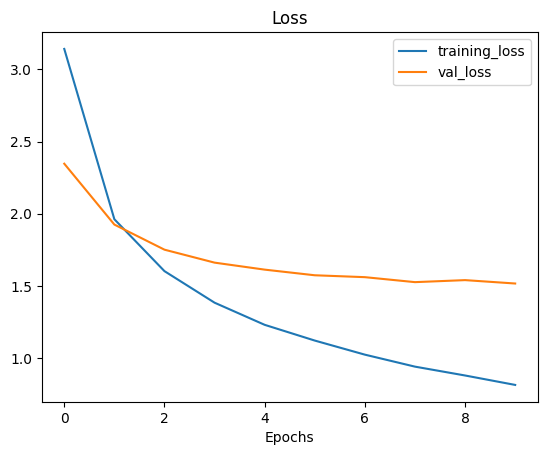

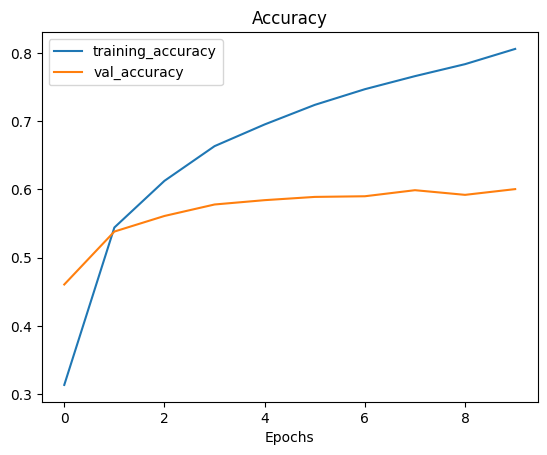

In [11]:
plot_loss_curves(history_1)

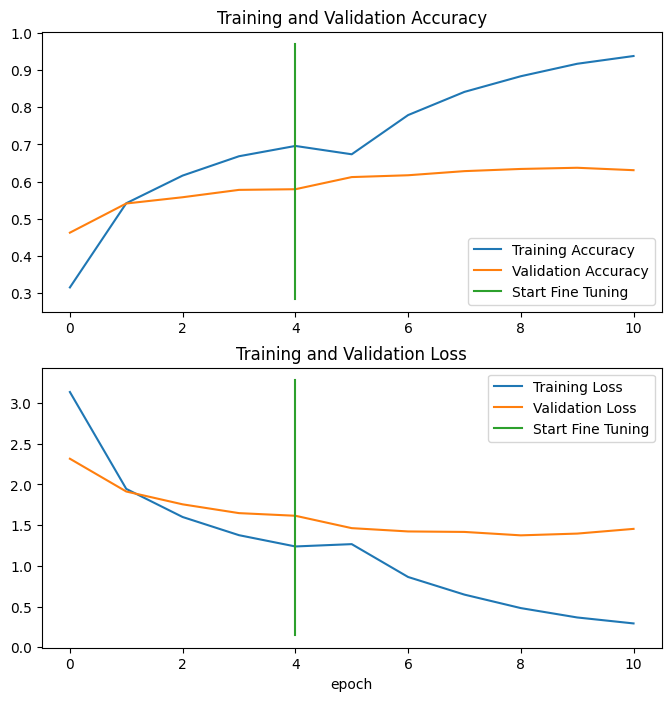

In [12]:
compare_histories(history_2, history_fine_tune)

In [13]:
print(f"Model_1 test accuracy: {model_1_results[1]*100:.2f}%")
print(f"Model_2 test accuracy: {model_2_results[1]*100:.2f}%")

Model_1 test accuracy: 64.32%
Model_2 test accuracy: 67.43%


The dataset that these models were trained on is 10% of the Food101 dataset. All 101 classes are present, but only 10% of the images for each class are used. After training for 10 epochs, the feature-extraction model achieved ~64% test accuracy, and the fine-tuned model which trained for 5 epochs first and then was fine-tuned for 5 more epochs achieved ~67% test accuracy. This is a 3% improvement, so it seems that the fine-tuning approach is better, and maybe it could have improved even more if I had unfrozen more of the top layers (20 or 30 instead of 10) in the base model.

One thing to note, however, is that both models seemed to be overfitting on the training data, so maybe I should have included a data augmentation layer in the models or tried to train on the full dataset, instead of only 10% of the data.

## 2. Recreate the first model (the feature extraction model) with [`mixed_precision`](https://www.tensorflow.org/guide/mixed_precision) turned on.

* Does it make the model train faster?
* Does it affect the accuracy or performance of our model?
* What are the advantages of using `mixed_precision` training?

In [14]:
from tensorflow.keras import mixed_precision

# Set global policy for mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Recreate model_1
base_model = tf.keras.applications.EfficientNetV2B2(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
x = layers.Dense(len(train_data.class_names), name="dense_logits")(x)

# Setting dtype to float32 to override global policy of mixed_float16 for outputs
outputs = layers.Activation("softmax", dtype="float32", name="output_layer")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Train the model for 10 epochs
history_3 = model_3.fit(train_data,
                        epochs=10,
                        validation_data=test_data,
                        validation_steps=int(0.25*len(test_data)))

Epoch 1/10
237/237 [==============================] - 24s 50ms/step - loss: 3.1418 - accuracy: 0.3172 - val_loss: 2.3464 - val_accuracy: 0.4594
Epoch 2/10
237/237 [==============================] - 9s 38ms/step - loss: 1.9552 - accuracy: 0.5477 - val_loss: 1.9344 - val_accuracy: 0.5259
Epoch 3/10
237/237 [==============================] - 9s 39ms/step - loss: 1.5899 - accuracy: 0.6174 - val_loss: 1.7405 - val_accuracy: 0.5657
Epoch 4/10
237/237 [==============================] - 9s 38ms/step - loss: 1.3979 - accuracy: 0.6578 - val_loss: 1.6574 - val_accuracy: 0.5753
Epoch 5/10
237/237 [==============================] - 9s 38ms/step - loss: 1.2298 - accuracy: 0.6990 - val_loss: 1.6166 - val_accuracy: 0.5776
Epoch 6/10
237/237 [==============================] - 9s 38ms/step - loss: 1.1225 - accuracy: 0.7267 - val_loss: 1.6202 - val_accuracy: 0.5733
Epoch 7/10
237/237 [==============================] - 9s 39ms/step - loss: 1.0218 - accuracy: 0.7551 - val_loss: 1.5517 - val_accuracy: 0.589

In [15]:
model_3_results = model_3.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 1.3461 - accuracy: 0.6402


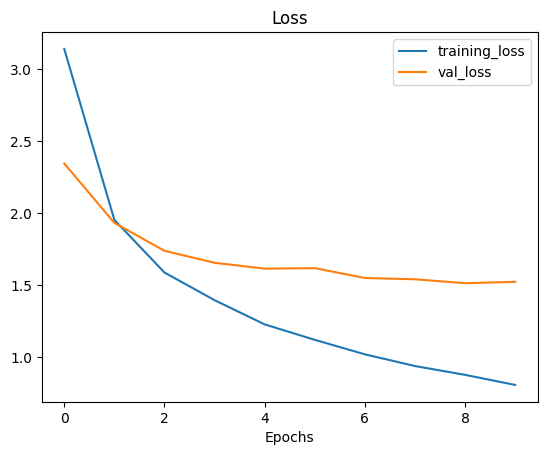

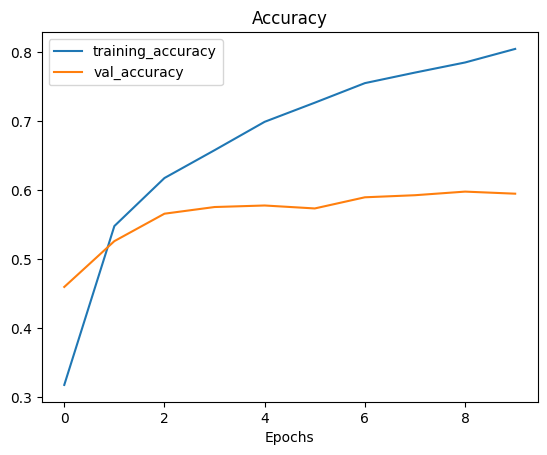

In [16]:
plot_loss_curves(history_3)

The final test accuracy of the model using mixed precision was ~64%, which is pretty much the same as the first model, so it seems that using mixed precision didn't help with the model's accuracy. However, the mixed precision model trained considerably faster, taking about 9 seconds per epoch compared to 14 seconds per epoch for the first model. It seems that using mixed precision **was** helpful for faster training, and I think if I used a bigger dataset or a more complex model I could see even more improvement in the training times.